In [4]:
import gym
from gym import spaces
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import time

In [5]:
########### variables #########
BALANCE = 1000
SPREAD = 0.0005
SIMULATION_DURATION = "10s"
TIMESTEP = 1
LEVERAGE = 1
PRICE = 1.2
VOLATILITY = volatility = 0.01/100
NB_STOCK = 50
###############################

In [6]:
class EnvTest2(gym.Env):
    def __init__(self, balance=BALANCE, spread=SPREAD, simulation_duration=SIMULATION_DURATION,timestep=TIMESTEP,
                leverage=LEVERAGE, price=PRICE, volatility=VOLATILITY, nb_stock=NB_STOCK):
        self.starting_balance = balance # valeur du porte feuille
        self.spread = spread # valeur du spread
        self.simulation_duration = simulation_duration # durée de la simulation demandées
        self.timestep = timestep # simulation sur un pas de 1 seconde
        self.leverage = leverage
        self.price = price
        self.volatility = volatility
        self.nb_stock = nb_stock
        self.text = False
        self.max_time = self.timeConverter(self.simulation_duration) # temps maximum d'un épisode
        
        self.action_spaces = spaces.Discrete(3) # 0 = achat, 1 = nothing, 2 = vendre
        self.observation_spaces = spaces.Box(low=-np.inf,
                                           high=np.inf,
                                           shape=(1,),
                                           dtype=np.float32)
        
        np.set_printoptions(precision=5)
        self.reset()
        
    def step(self, action):
        """effectue un 'step' dans la simulation"""
        done = False
        if action == 0:
            self.buy()
        
        
        
        
        self.current_time += self.timestep
        if self.current_time >= self.max_time:
            done = True
            for i in range(len(self.pending_transaction)):
                print(f"Transaction no {i} : {self.pending_transaction[i]}")
                
        self.calculateProfitAndLoss()
        self.simulateNextPrice()
        next_state = self.getObservations()
        reward = self.getReward()
        info = {}
        return next_state, reward, done, info
    
                      
    def reset(self):
        """Reinitialise les variables modifiable"""
        
        # Reset variables
        self.current_time = 0
        self.current_price = self.price
        self.current_balance = self.starting_balance
        self.current_spread = self.calculateSpread()
        self.current_profit_and_loss = 0
        
        
        # History management
        self.price_history = []
        self.savePriceHistory()
        self.balance_history = []
        self.saveBalanceHistory()
        self.profit_and_loss_history = []
        self.saveProfitAndLoss()
        self.pending_transaction = []
        
        #self.buy_price = None
        #self.sell_price = None
        

        next_state = self.getObservations()
        return next_state
        
    def render(self):
        # Define a function thath displays the environment
        fig, axes = plt.subplots(3,1, figsize = (12, 6), dpi = 200)
        fig.subplots_adjust(hspace=0.4) 

        axes[0].plot(self.price_history)
        axes[0].set_ylabel("EUR/USD")
        axes[0].set_title("EUR/USD simulé*")
        axes[1].plot(self.profit_and_loss_history)
        axes[1].set_ylabel("EUR")
        axes[1].set_title("Profit & Loss")
        axes[2].plot(self.balance_history)
        axes[2].set_ylabel("EUR")
        axes[2].set_title("Valeur du porte-feuille")
        axes[2].set_xlabel("Secondes")
        
    # Méthods that allow to save the histories   
    def savePriceHistory(self):
        """Define a function thath logs the prices"""
        self.price_history.append(self.current_price)
    
    def saveBalanceHistory(self):
        """Define a function thath logs the balance"""
        self.balance_history.append(self.current_balance)
    
    def saveProfitAndLoss(self):
        """Define a function thath logs the profits & losses"""
        self.profit_and_loss_history.append(self.current_profit_and_loss)
        
    
    
    # Methods that allow to manage price simulation
    def updateVolatility(self):
        """Define a function to update the volatility""" 
        return rnd.uniform(0.005, 0.02/100)
       
    def jumpDiffusion(self):
        """Define a function to calculate the jump size based on jump diffusion model"""
        lambda_j = 0.001
        mu_j = -0.1/5
        sigma_j = 0.1/100
        jump = 0
        if rnd.uniform(0, 1) < lambda_j:
            jump = rnd.normalvariate(mu_j, sigma_j)
        return jump
  
    def simulateNextPrice(self):
        """Define a function that generates the next price"""
        # Calculate the next price as a random walk with jumps
        jump = self.jumpDiffusion()
        volatility = self.updateVolatility()
        self.current_price += rnd.normalvariate(0, volatility) + jump
        self.savePriceHistory()

        
        
    # Méthods to calculate spread, le P&L, etc    
    def calculateSpread(self):
        """Define a function that calculate the spread"""
        return self.spread * self.current_price
    
    def calculateProfitAndLoss(self):
        total_PL = 0
        if len(self.pending_transaction) == 0:
            self.current_profit_and_loss = 0
        else:    
            for el in self.pending_transaction:
                total_PL += (el[1] - self.current_price)  * el[2]

            self.current_profit_and_loss = round(total_PL, 2)
            
        print(f"Current P&L : {self.current_profit_and_loss}")
    
    
    # Methods that allow to manage the different actions of the agent
    def buy(self):
        """Define a function that manage the purchases"""
        price = self.current_price # ajout de la marge du bid ?
        spread = self.calculateSpread() # spread = marge ?
        amount = self.nb_stock
        
        total_cost = (amount * self.leverage * price) + spread
        if total_cost > self.current_balance:
            print(f"Not enough balance to make the purchase")
            print("----")
            print()
            return
        
        self.current_balance -= round(total_cost,2)
        self.saveBalanceHistory()
        self.saveProfitAndLoss()
        self.pending_transaction.append(("buy", price, amount))
        print(f"Bought {amount} contract(s) for {round(total_cost,2)} EUR at {round(price,5)}")
        print(f"Balance : {round(self.current_balance,2)}€")
        print("----")
        print()
              
    def sell(self):
        """Define a function that manage the sales"""
        price = self.current_price # retrait de la marge du ask ?
        spread = self.calculateSpread() # spread = marge ?
        amount = self.nb_stock
        
        total_cost = (amount * leverage * price) + spread
        if total_cost > self.current_balance:
            print(f"Not enough balance to make the purchase")
            
            return
        
        self.current_balance -= total_cost
        print(f"Bought {amount} contract(s) for {round(total_cost,2)}  EUR at {round(price,5)}")
        print(f"Balance : {self.current_balance}€")
    
    
    def getObservations(self):
        """Observations management"""
        obs_1 = self.price_history[-1] ## Valeur actuelle de la courbe/last value de l'histo
        obs_2 = self.balance_history[-1]
        return np.array([obs_1, obs_2])

    def getReward(self):
        """Rewards management"""
        return 1
    
    
    
    # Methods to manage manual simulation time
    def timeConverter(self, time):
        """Convert manual duration
        Return the maximum duration in seconds (or depanding on the time step)"""
        number = ""
        value = ""
        for string in time:
            if string.isdigit():
                number += string
            else:
                value += string
        if not self.translate(value):
            print("Incorrect simulation duration...")
            exit() # ajouter la gestion de mauvaises données
        time_converted = int(number) * self.translate(value)
        return time_converted
    
    def translate(self, value):
        """function that translate 'str' and returns the value in seconds"""
        
        ## Time constant in seconds
        SECONDE = 1.0
        MINUTE = 60.0
        HOUR = 60.0 * MINUTE
        DAY = 24.0 * HOUR
        WEEK = 7.0 * DAY
        MONTH = 30.0 * DAY
        YEAR = 365.0 * DAY
        
        d = {SECONDE : ["s", "seconde", "secondes", "sec", "secs"],
            MINUTE : ["m", "min", "minute", "minutes", "mins", "minutes"],
            HOUR : ["h", "heure", "hour", "hours", "heures"],
            DAY : ["d", "j", "jour", "day", "jours"],
            WEEK : ["w", "week", "semaine", "weeks", "semaines"],
            YEAR : ["y", "year", "année", "annee", "an", "années", "years"]
            }

        
        d_inv = {}
        for k, v in d.items():
            for i in v:
                d_inv.update({i: k})
        return d_inv.get(value.lower())
                
        """for key in d.keys():
            if value.lower() in key:
                print(f"value lower : {value.lower()}")
                if key == "seconde":
                    return SECONDE
                elif key == "minute":
                    return MINUTE
                elif key == "hour":
                    return HOUR
                elif key == "day":
                    return DAY
                elif key == "week":
                    return WEEK
                elif key == "year":
                    return YEAR
                
        return False"""

env observation spaces : (1,)
env action spaces : 3

state : [   1.2 1000. ]
Bought 50 contract(s) for 60.0 EUR at 1.2
Balance : 940.0€
----

Current P&L : 0.0
Bought 50 contract(s) for 60.08 EUR at 1.20154
Balance : 879.92€
----

Current P&L : -0.08
Bought 50 contract(s) for 59.54 EUR at 1.19075
Balance : 820.38€
----

Current P&L : 1.0
Bought 50 contract(s) for 59.39 EUR at 1.18779
Balance : 760.99€
----

Current P&L : 1.45
Bought 50 contract(s) for 59.37 EUR at 1.18748
Balance : 701.62€
----

Current P&L : 1.51
Bought 50 contract(s) for 59.35 EUR at 1.187
Balance : 642.27€
----

Current P&L : 1.63
Bought 50 contract(s) for 59.31 EUR at 1.18624
Balance : 582.96€
----

Current P&L : 1.86
Bought 50 contract(s) for 59.47 EUR at 1.18946
Balance : 523.49€
----

Current P&L : 0.73
Bought 50 contract(s) for 59.39 EUR at 1.18788
Balance : 464.1€
----

Current P&L : 1.36
Bought 50 contract(s) for 59.32 EUR at 1.1864
Balance : 404.78€
----

Transaction no 0 : ('buy', 1.2, 50)
Transaction no 1 

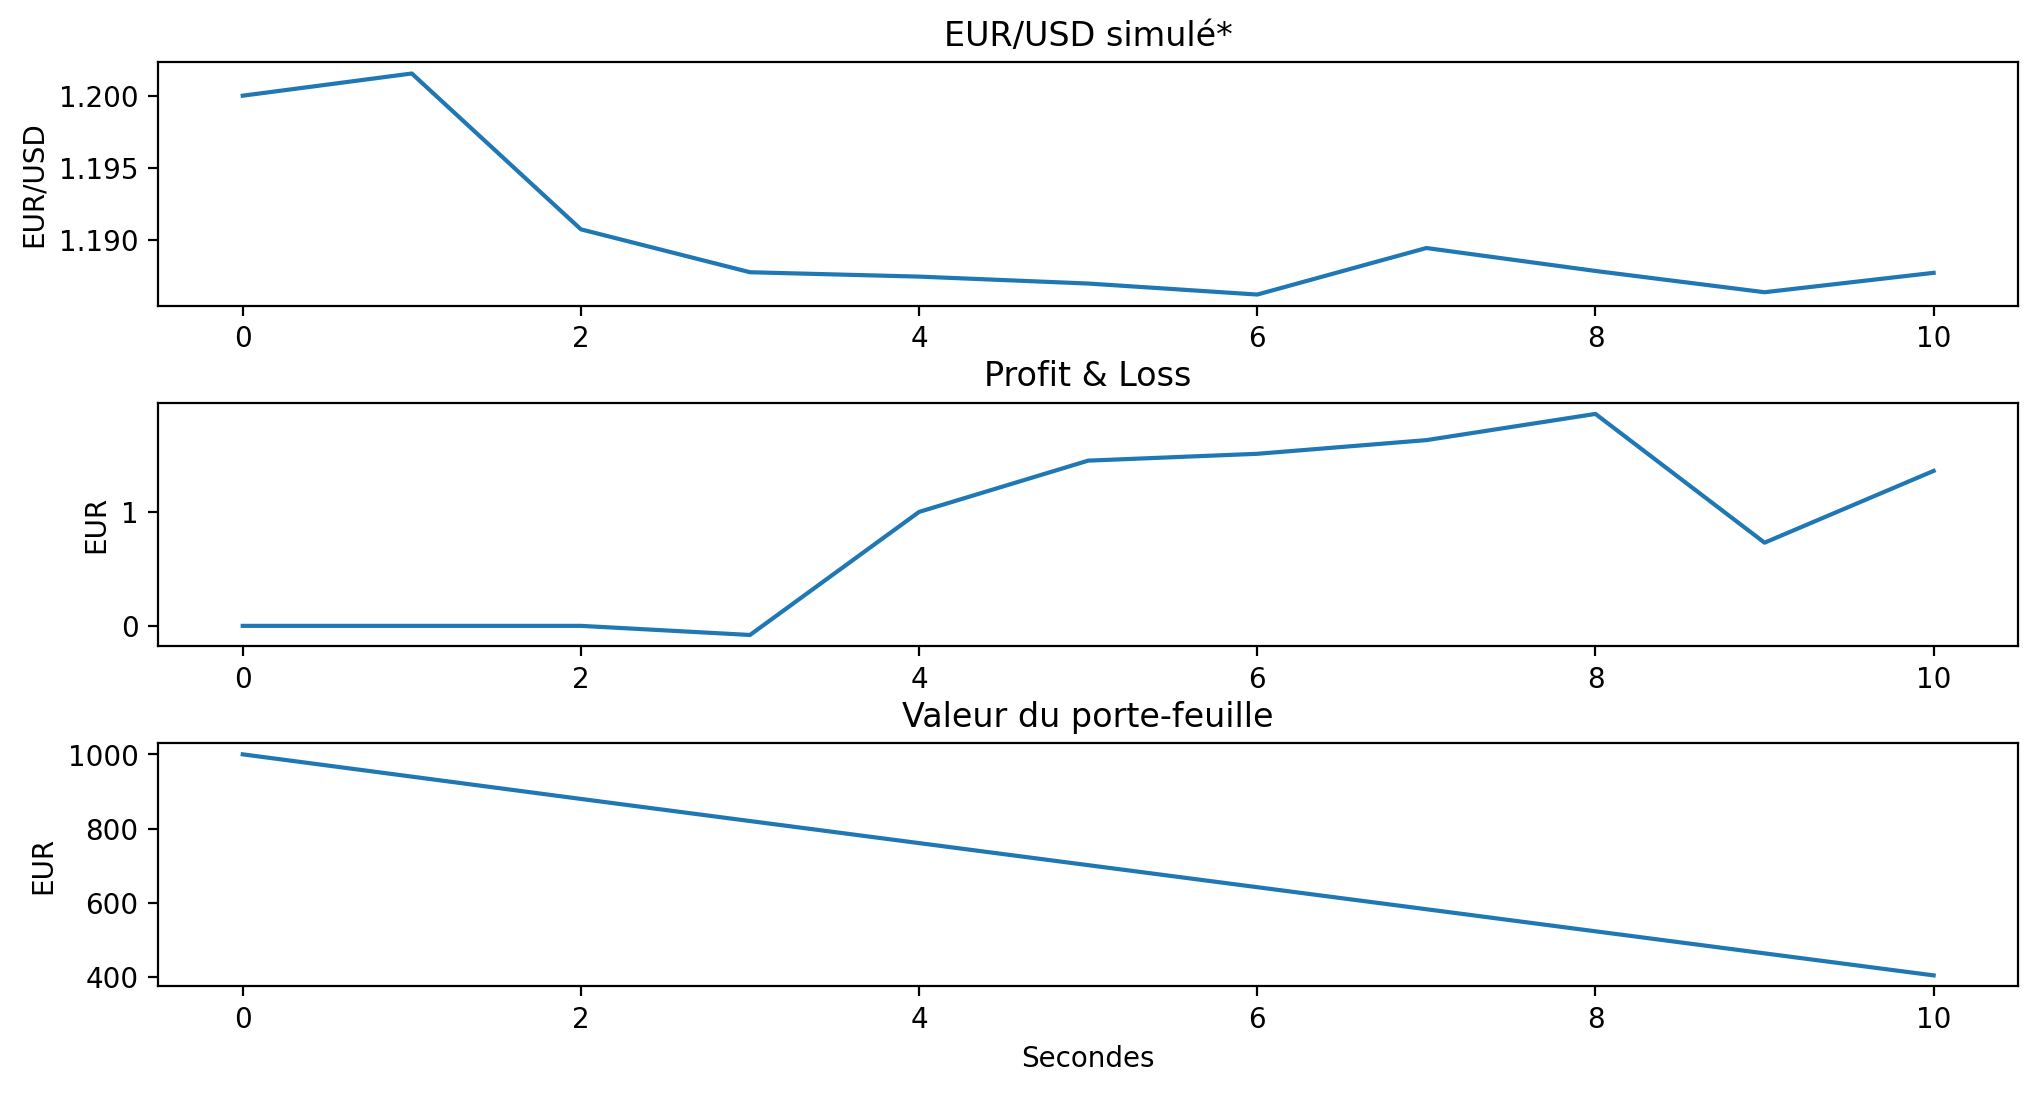

In [7]:


env = EnvTest2()
#agent = Agent()
print(f"env observation spaces : {env.observation_spaces.shape}")
print(f"env action spaces : {env.action_spaces.n}")
print()
num_action = env.action_spaces.n
num_observation = env.observation_spaces.shape[0]

nb_max_episode = 1

for episode in range(nb_max_episode):
    state = env.reset()
    print(f"state : {state}")
    done = False
    score = 0
    compteur = 0
    while not done:
        compteur += 1
        action = Agent.act()
        
        next_state, reward, done, _ = env.step(0)
        
        score += reward
        state = next_state
        
        if done:
            env.render()
            #print(f"episode : {episode+1} - score total : {score}")
            pass

In [8]:
import csv
from datetime import datetime, timedelta
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

class MarketDataApp(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.order_book = {}

    def error(self, reqId, errorCode, errorString):
        print("Error {}: {}".format(errorCode, errorString))

    def historicalData(self, reqId, bar):
        if bar.date[-8:] == "16:00:00":
            if "BID" not in self.order_book:
                self.order_book["BID"] = {}
            if "ASK" not in self.order_book:
                self.order_book["ASK"] = {}
            self.order_book["BID"][bar.open] = bar.volume
            self.order_book["ASK"][bar.close] = bar.volume

    def get_order_book(self, filename):
        contract = Contract()
        contract.symbol = "EUR"
        contract.secType = "CFD"
        contract.currency = "USD"
        contract.exchange = "SMART"
        end_time = datetime(year=2023, month=2, day=24, hour=14, minute=0, second=0)
        start_time = end_time - timedelta(minutes=1)
        end_time_str = end_time.strftime("%Y%m%d-%H:%M:%S")
        self.reqHistoricalData(1, contract, end_time_str, "1 day", "1 hour", "BID", 1, 1, False, [])
        self.run()
        self.print_order_book(filename)

    def print_order_book(self, filename):
        if not self.order_book:
            print("Error: order book data not available")
            return
        with open(filename, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['BID Size', 'Price', 'ASK Size'])
            for price in sorted(self.order_book["BID"], reverse=True):
                bid_size = self.order_book["BID"][price]
                if price in self.order_book["ASK"]:
                    ask_size = self.order_book["ASK"][price]
                else:
                    ask_size = "-"
                writer.writerow([bid_size, price, ask_size])


app = MarketDataApp()
app.connect("127.0.0.1", 7496, 0)
app.get_order_book("eurusd_order_book.csv")
app.disconnect()


Error 502: Couldn't connect to TWS. Confirm that "Enable ActiveX and Socket EClients" 
is enabled and connection port is the same as "Socket Port" on the 
TWS "Edit->Global Configuration...->API->Settings" menu. Live Trading ports: 
TWS: 7496; IB Gateway: 4001. Simulated Trading ports for new installations 
of version 954.1 or newer:  TWS: 7497; IB Gateway: 4002
Error 504: Not connected
Error: order book data not available


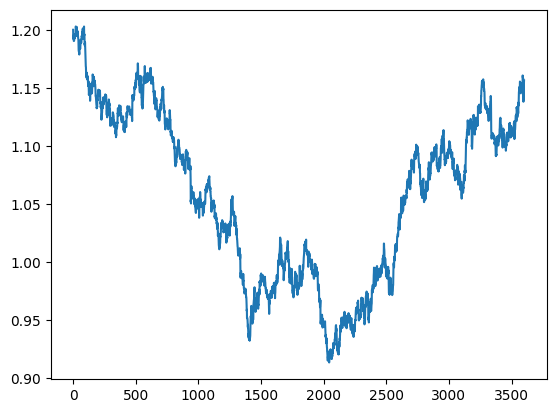

In [38]:
# ajouter une fois l'env entièrement débuggé
import random
import time

## Constantes de temps en secondes
SECONDE = 1.0
MINUTE = 60.0
HOUR = 60.0 * MINUTE
DAY = 24.0 * HOUR
WEEK = 7.0 * DAY
MONTH = 30.0 * DAY
YEAR = 365.0 * DAY

# Define initial price and volatility
price = 1.2
volatility = 0.01/100


# Define a function to update the volatility each minute
def update_volatility():
    return random.uniform(0.005, 0.02/100)


# Define a function to calculate the jump size based on jump diffusion model
def jump_diffusion():
    lambda_j = 0.001
    mu_j = -0.1/5
    sigma_j = 0.1/100
    jump = 0
    if random.uniform(0, 1) < lambda_j:
        jump = random.normalvariate(mu_j, sigma_j)
    return jump

prices = []
prices.append(price)

# Simulate prices for one day
for i in range(int(HOUR)):
    # Calculate the next price as a random walk with jumps
    jump = jump_diffusion()
    volatility = update_volatility()
    price += random.normalvariate(0, volatility) + jump
    prices.append(price)
    # Print the current time and price
    #print(time.strftime("%Y-%m-%d %H:%M:%S"), round(price, 6))
    # Wait for one second
    #time.sleep(1)
    
plt.plot(prices)
plt.show()

In [26]:
class EnvTest(gym.Env):
    def __init__(self, balance=100, spread=0.05, max_variation=0.00005, simulation_duration="10", nb_stock=10, leverage=1.1):
        self.spread = spread # valeur du spread
        self.max_variation = max_variation # variation maximale de la courbe en pourcentage
        self.simulation_duration = simulation_duration # durée de la simulation demandées
        self.nb_stock = nb_stock
        self.leverage = leverage
        self.text = False
        self.action_spaces = spaces.Discrete(3) # 0 = achat, 1 = nothing, 2 = vendre
        self.observation_spaces = spaces.Box(low=-np.inf,
                                           high=np.inf,
                                           shape=(2,),
                                           dtype=np.float32)
        
        self.starting_balance = balance # valeur du porte feuille
        self.timestep = 1.0 # simulation sur un pas de 1 seconde
        self.max_time = self.timeConverter(self.simulation_duration) # temps maximum d'un épisode
        
        np.set_printoptions(precision=5)
        self.reset()
        print(f"Balance : {self.balance} - spread : {(self.spread*100)}%")
        
    def step(self, action):
        """effectue un 'step' dans la simulation"""
        
        if self.current_time >= self.max_time:
            self.done = True
        self.current_time += self.timestep
        
        self.checkPos(action)
        self.saveBalanceData()
        self.generateCurveData()
        self.setObservations()       
        return self.next_state, self.reward, self.done, self.info
    
                      
    def reset(self):
        """Reinitialise les variables modifiable"""
        self.balance = self.starting_balance
        self.curve_values = [] 
        self.balance_values = [self.balance]
        self.current_curve_value = self.initializeCurve()
        self.profit_loss = 0.0
        
        self.current_time = 0.0
        self.reward = 0.0
        self.done = False
        self.info = {}
        
        self.state = np.zeros(self.observation_spaces.shape[0])
        self.next_state = self.state
        last_action = 1 # derniere action effectué par l'agent, initialisé à 1 "nothing"
        self.last_buy_or_sell_value = False # valeur de la courbe lors de l'achat ou de la vente
        
        self.pos = "Pas de position"        
        
        return self.next_state, self.reward, self.done, self.info
    
        
    def render(self):
        """Affiche l'environnement, dans notre cas la courbe"""
        #print(f"balance historique : {self.balance_values}")
        fig, axes = plt.subplots(2,1, figsize = (12, 5), dpi = 200)
        fig.subplots_adjust(hspace=0.3) 

        axes[0].plot(self.curve_values)
        axes[0].set_ylabel("EUR/USD")
        axes[0].set_title("EUR/USD simulé*")
        axes[1].plot(self.balance_values)
        axes[1].set_ylabel("EUR")
        axes[1].set_title("Valeur du porte-feuille")
        axes[1].set_xlabel("Secondes")
        
    def initializeCurve(self):
        """Initialise une courbe entre les valeurs min et max"""
        minimum_value = 1.053
        maximum_value = 1.062
        value = rnd.uniform(minimum_value, maximum_value)
        self.curve_values.append(value)
        return value
    
    def generateCurveData(self):
        """génère la prochaine valeur de la courbe en fonction du taux de variation
        sauvegarde la valeur dans l'historique"""
        variation = rnd.uniform(-self.max_variation, self.max_variation)
        self.current_curve_value += self.current_curve_value * variation
        self.saveCurveData()
    
    def saveCurveData(self):
        """Sauvegarde les données de la courbe dans une liste"""
        self.curve_values.append(self.current_curve_value)

    def saveBalanceData(self):
        """Sauvegarde les données du porte feuille dans une liste"""
        self.balance_values.append(self.balance)
        
    def updateProfitAndLoss(self, action):
        if self.last_buy_or_sell == False: # Si l'agent n'a jamais acheté ou vendu
            return 0.0
    
    def setObservations(self):
        """Gestion des observations"""
        self.next_state[0] = self.curve_values[-1] ## Valeur actuelle de la courbe/last value de l'histo
        self.next_state[1] = self.profit_loss ## Valeur actuelle des profits/pertes
              
    def setReward(self):
        """Gestion des rewards"""
        pass
    
    def checkPos(self, action):
        if action == 0:
            if self.pos == "Pas de position":
                if self.checkActionCostCalculation(action):
                    if self.text:
                        print(f"Achat de {self.nb_stock} stocks à {self.current_curve_value}")
                        print(f"Current balance : {self.balance}")
                        print()
                    self.pos = "Achat"
                    self.last_action = 0
                    self.last_buy_or_sell_value = self.current_curve_value
            elif self.pos == "Vente":
                if self.text: print(f"Fin de la position de vente de {self.nb_stock} stocks à {self.last_buy_or_sell_value}")
                self.checkActionGainCalculation(action)
                self.pos = "Pas de position"
                self.last_action = 0
                self.last_buy_or_sell_value = False
            else:
                self.last_action = 0

        if action == 2:
            if self.pos == "Pas de position":
                if self.checkActionCostCalculation(action):
                    if self.text:
                        print(f"Vente de {self.nb_stock} stocks à {self.current_curve_value}")
                        print(f"Current balance : {self.balance}")
                        print()
                    self.pos = "Vente"
                    self.last_action = 2
                    self.last_buy_or_sell_value = self.current_curve_value
            elif self.pos == "Achat":
                if self.text: print(f"Fin de la position d'achat de {self.nb_stock} stocks à {self.last_buy_or_sell_value}")
                self.checkActionGainCalculation(action)
                self.pos = "Pas de position"
                self.last_action = 2
                self.last_buy_or_sell_value = False
            else:
                self.last_action = 2

        if action == 1:
            self.last_action = 1
    
    def checkActionCostCalculation(self, action):
        if action == 0 or action == 2:
            if self.balance > ((2*self.nb_stock) * self.current_curve_value):
                self.balance -= (self.nb_stock * self.current_curve_value) # + ((1 + self.spread) * self.current_curve_value)   
                return True
            else:
                print("Fonds insuffisant...")
                return False

    def checkActionGainCalculation(self, action):
        if action == 0 or action ==2:
            self.balance += self.nb_stock * (self.current_curve_value * self.leverage)
            
        if (self.nb_stock * self.current_curve_value) >= 0:              
            if self.text : print(f"Balance : +{(self.nb_stock * self.current_curve_value)}g")
        else:
            if self.text : print(f"Balance : -{(self.nb_stock * self.current_curve_value)}g")
            #print()
    
    def timeConverter(self, time):
        """Convertie la durée entrée manuellement
        Renvois la durée maximale en seconde (ou en fonction du time step)"""
        number = ""
        value = ""
        for string in time:
            if string.isdigit():
                number += string
            else:
                value += string

        if not self.translate(value):
            print("Durée de simulation incorrect...")
            exit() # ajouter la gestion de mauvaises données
        time_converted = int(number) * self.translate(value)
        return time_converted
    
    def translate(self, value):
        """fonction qui permet de traduire et la renvoie en seconde"""
        
        ## Constantes de temps en secondes
        SECONDE = 1.0
        MINUTE = 60.0
        HOUR = 60.0 * MINUTE
        DAY = 24.0 * HOUR
        WEEK = 7.0 * DAY
        MONTH = 30.0 * DAY
        YEAR = 365.0 * DAY
        
        d = {"seconde" : ["s", "seconde", "secondes", "sec", "secs"],
            "minute" : ["m", "min", "minute", "minutes", "mins", "minutes"],
            "hour" : ["h", "heure", "hour", "hours", "heures"],
            "day" : ["d", "j", "jour", "day", "jours"],
            "week" : ["w", "week", "semaine", "weeks", "semaines"],
            "year" : ["y", "year", "année", "annee", "an", "années", "years"]
            }

        for key in d.keys():
            if value.lower() in key:
                if key == "seconde":
                    return SECONDE
                elif key == "minute":
                    return MINUTE
                elif key == "hour":
                    return HOUR
                elif key == "day":
                    return DAY
                elif key == "week":
                    return WEEK
                elif key == "year":
                    return YEAR
                
        return False

    
class Agent():
    def __init__(self):
        pass
    
    def act(self):
        pass

Balance : 100 - spread : 5.0%
env observation spaces : (2,)
env action spaces : 3



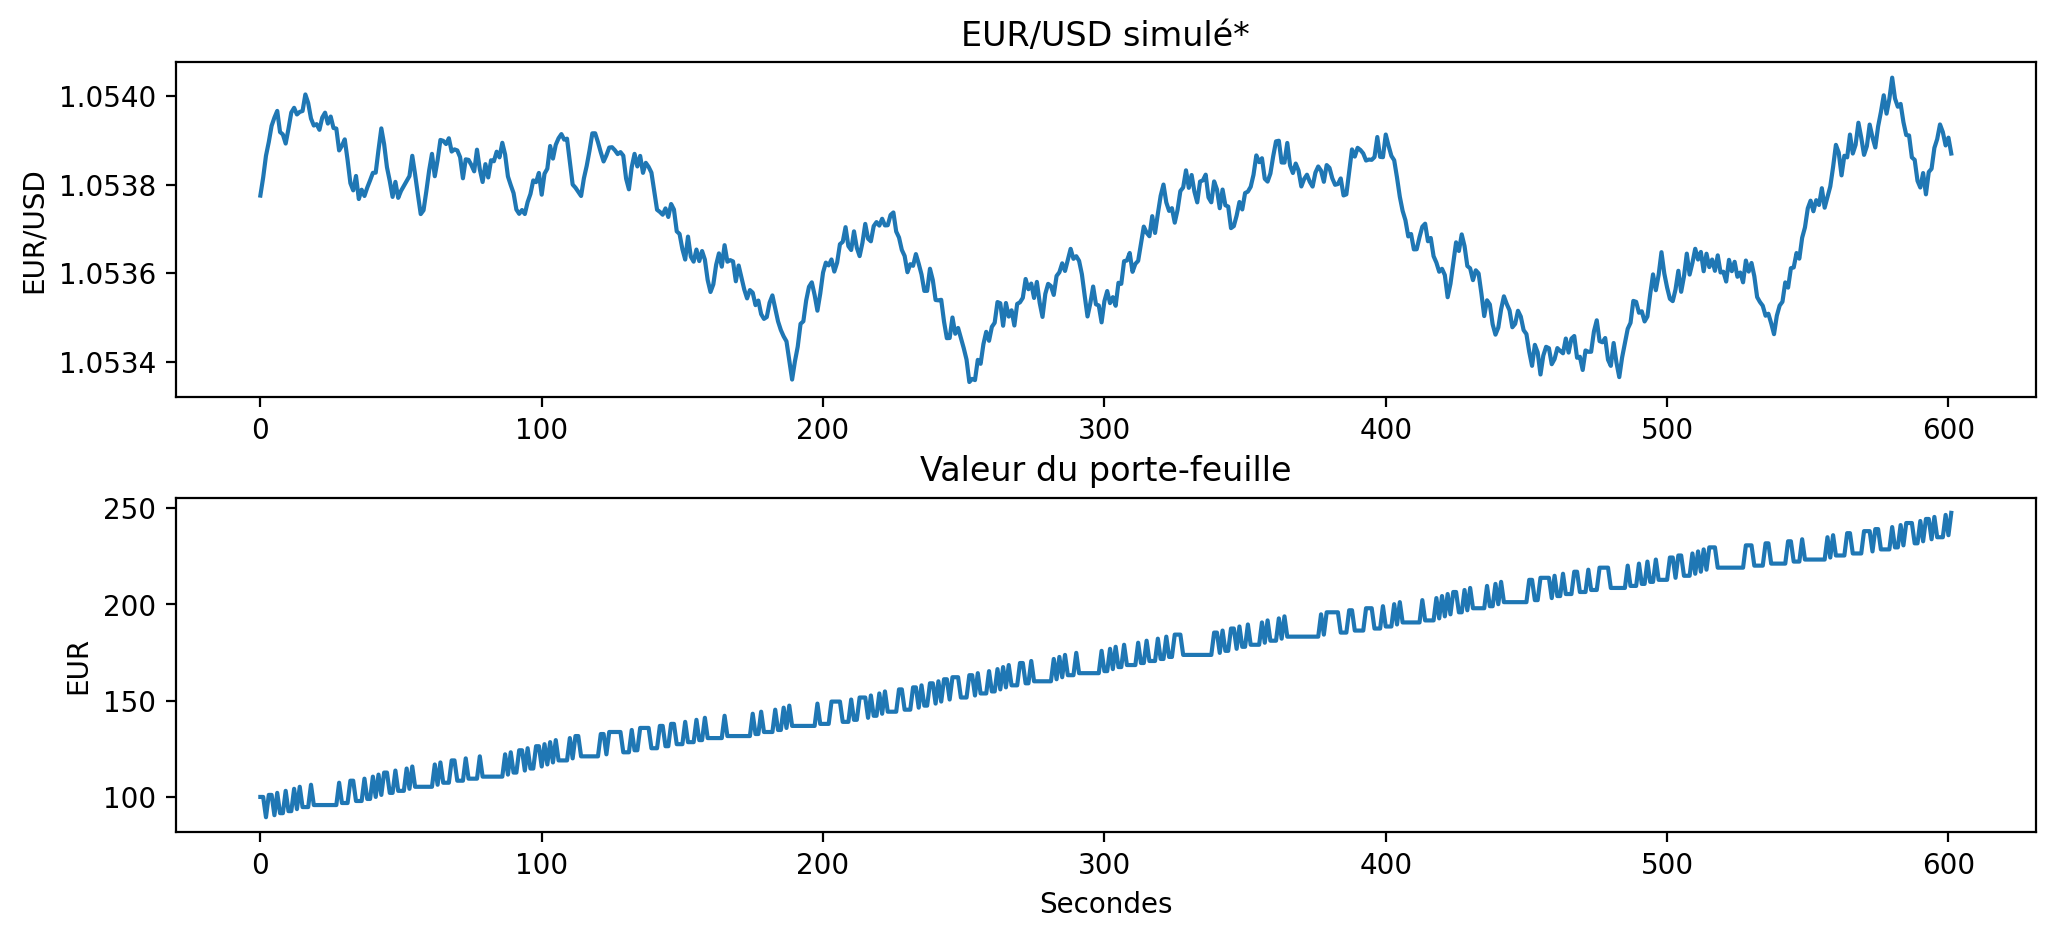

In [27]:
env = EnvTest(simulation_duration="10min")
agent = Agent()
print(f"env observation spaces : {env.observation_spaces.shape}")
print(f"env action spaces : {env.action_spaces.n}")
print()
num_action = env.action_spaces.n
num_observation = env.observation_spaces.shape[0]

nb_max_episode = 1

for episode in range(nb_max_episode):
    state = env.reset()
    done = False
    score = 0
    compteur = 0
    while not done:
        
        action = env.action_spaces.sample()
        """compteur += 1
        if compteur % 15:
            next_state, reward, done, _ = env.step(0)
        else:
            next_state, reward, done, _ = env.step(2)"""
        
        next_state, reward, done, _ = env.step(action)
        
        score += reward
        state = next_state
        
        if done:
            env.render()
            #print(f"episode : {episode+1} - score total : {score}")
            pass